# Kanban metrics spreadsheet calculations via Python Notebook 

See the following for more inspiration:

https://actionableagile.com/

https://bitbucket.org/marcobresciani/aamfp

There is much confusion in the Agile and Lean community about the names of the various cycle times. Lets clarify the names given to the various timings associated with work items moving through the system. 

We must remember that flow efficiency deals with the touch times and the wait times while in the process’s FLOW TIME. Wait times spent outside the process’s FLOW TIME, which is Queue Time or Delivery Time, are often wrongly included in Flow efficiency calculations.


![Key timings diagram](Cycle-Times-Overview.png "Key Timings")
<!---
![alt text](https://kanbanize.com/blog/wp-content/uploads/2019/02/TameFlow-Times-1.png "Logo Title Text 1")
--->

## Outputs

### Speadsheet with four worksheets similar to Marco's aamfp sheet

* activities_df : Workitems source data
* metrics_df : Calculated Metrics
* data_df : Calculated Metrics
* distribution_df : Calculated Metrics

### Charts as PNG Images

* Scatterplot of work items done
* Age of Work In Process
* Flow Time histogram
* CFD - Cummulative Flow Diagram
* Daily Run Chart
* Flow Effiency Chart
* Ratio of WorkItem types


## Import libraries

In [268]:

import pandas as pd # Python Data Analysis Library https://pandas.pydata.org/
import numpy as np # NumPy is the fundamental package for scientific computing with Python. http://www.numpy.org/

import matplotlib.pyplot as plt  #Plotting library
import matplotlib.dates as mdates #Dates information from the plotting library
from matplotlib.dates import MONDAY

from scipy import stats # Maths functions - Need to get Weibull function for Flow Time histogram.

import seaborn as sns # Finctions for computing colours

In [269]:
# Matplotlib axis locator functions
mondays = mdates.WeekdayLocator(MONDAY) # every monday
alldays = mdates.DayLocator() #every day

In [270]:
from io import StringIO #Read and write strings as files

In [271]:
percentiles=[50,70,85,95]

In [272]:
today_str=pd.to_datetime('today').date().strftime("%Y-%m-%d")
today_nice_str=pd.to_datetime('today').date().strftime("As at %a %d %b %Y - ISOWeek %V")

In [273]:
today_str, today_nice_str

('2019-03-12', 'As at Tue 12 Mar 2019 - ISOWeek 11')

## Load in the stories/issues data activity.

Issue/Story activity data captured in spreadsheet or extracted from issue tracking tool, such as Jira or etc.

Either load in from spreadsheet or copy and paste from Excel or LibreOffice. 

In [275]:
# Specify the source of the Work Item Data
#SOURCE="AAMfP Excel"
SOURCE="AAMfP TSV pasted"
#SOURCE="Custom"

### Load in Activities from AAMfP excel sheet 

https://bitbucket.org/marcobresciani/aamfp

In [276]:
if SOURCE=="AAMfP Excel":
    activities_df = pd.read_excel('AAMfP.xlsx',sheet_name='Activities')

### Load in Activities from next-gen Jira board extract

https://www.link_to_extract_utility_to_go_here.com

In [277]:
if SOURCE=="Custom":
    filename='BPDTS-coaching-Issues_2019-03-11.xlsx'
    activities_df = pd.read_excel(filename,sheet_name='Activities')


### Copy and paste activities from Excel or LibreOffice

In [278]:
#DATASHEET = StringIO("""
#
#""")
DATASHEET = StringIO("""
ID	Link	Name	Backlog	Next	In-progress	Done	CoS	WIT	Deadline	Blocked Days	Deleted	Labels
6		What is the longest you've been awake?	2019-02-09	2019-02-24	2019-02-24	2019-02-24	Fixed Date	A	2019-03-16		2019-02-24	
11		What are your favorite hot dog toppings?	2019-02-23	2019-02-23	2019-02-24	2019-02-25	Standard	B				
17		Where did you get your name?	2019-02-23	2019-02-23	2019-02-24	2019-02-25	Standard	B				
14		What is your favorite lunch meal?	2019-01-21	2019-02-24	2019-02-24	2019-02-25	Standard	B				
9		What do you do as excerise?	2019-02-24	2019-02-25	2019-02-25	2019-02-26	Standard	B				
13		which do you like better, being a passenger or driver?	2019-02-18	2019-02-25	2019-02-26	2019-02-26	Fixed Date	C	2019-02-25			
20		Have you ever fainted?	2019-02-23	2019-02-23	2019-02-23	2019-03-01	Standard	B		1	2019-03-01	
4		Have you ever bungee jumped?	2019-03-01	2019-03-01	2019-03-01	2019-03-01	Intangible	Q		1		
16		Have you ever jumped out of a plane?	2019-02-24	2019-03-01	2019-03-01	2019-03-03	Expedite	D				
10		Do you like flying?	2019-03-03	2019-03-03	2019-03-03	2019-03-03	Standard	D				
15		What are your favorite movies?	2019-03-03	2019-03-03	2019-03-03	2019-03-03	Standard	D				
18		What is your favorite school subject?	2019-03-03	2019-03-03	2019-03-04	2019-03-04	Standard	D			2019-03-04	
19		Do you swear often?	2019-03-04	2019-03-04	2019-03-04	2019-03-04	Standard	D				
2		Which do you like better, cars or trucks?	2019-03-04	2019-03-04	2019-03-04	2019-03-08	Standard	D		4		
3		Are you religious?	2019-03-08	2019-03-08	2019-03-08	2019-03-10	Standard	D			2019-03-10	
5		Do you have nice handwriting?	2019-03-01	2019-03-10	2019-03-10	2019-03-10	Fixed Date	Q	2019-03-18		2019-03-10	
8		Have you ever been on TV?	2019-03-04	2019-03-10	2019-03-10	2019-03-10	Intangible	D			2019-03-10	
12		Have you ever burnt your hair?	2019-03-10	2019-03-10	2019-03-10	2019-03-10	Expedite	E				
7		Have you ever ironed clothes?	2019-03-04	2019-03-10	2019-03-10	2019-03-11	Standard	D				
1		What is your favorite dinner meal?	2019-02-14	2019-02-14	2019-02-14		Intangible	F				
21		What is your favorite cereal?	2019-02-14	2019-02-14	2019-02-14		Standard	G				
33		Have you ever been to a zoo?	2019-02-14	2019-02-14	2019-02-14		Standard	G				
24		Where do you see yourself in ten years?	2019-03-06	2019-03-07	2019-03-07		Standard	B				
30		If you had to swap lives with someone famous, who would you choose?	2019-03-06	2019-03-07	2019-03-07		Standard	B				
35		What is your first memory?	2019-03-07	2019-03-07	2019-03-07		Expedite	B				
29		Which do you like better, TV or movies?	2019-02-26	2019-03-11	2019-03-11		Fixed Date	A	2019-03-09			
22		What is your favorite holiday?	2019-02-18	2019-02-18			Standard	G		27		
23		Have you ever slept outside?	2019-02-26				Fixed Date	A	2019-03-16			
25		What is your favorite season?	2019-02-14				Intangible	Q				
26		What is your favorite clothing brand?	2019-02-14				Intangible	G				
27		What is the strangest thing you've eaten?	2019-02-14				Standard	F				
32		What is your favorite Disney movie?	2019-02-21				Intangible	S				
42		What is your favorite dessert?	2019-02-21				Intangible	E				
28		What is your least favorite chore?	2019-02-23				Standard	B				
34		When is your birthday?	2019-02-23				Standard	B				
31		What is your favorite flavor of ice cream?	2019-02-26				Intangible	B				
38		If you could have a superpower, what would you choose?	2019-02-26				Intangible	Q				
36		Which do you like better, city or country?	2019-02-28				Intangible	B				
37		What is your favorite cheese?	2019-02-28				Intangible	B				
40		Where is you favorite place to eat?	2019-02-28				Expedite	B				
41		Which do you like better, rain or snow?	2019-03-07				Standard	S				
39		Which do you like better, beer or wine?	2019-03-11				Intangible	Q				
""")

In [279]:
if SOURCE=="AAMfP TSV pasted":
    activities_df=pd.read_csv(DATASHEET, sep="\t")

### Check if columns and activity data look OK.

In [280]:
activities_df.columns

Index(['ID', 'Link', 'Name', 'Backlog', 'Next', 'In-progress', 'Done', 'CoS',
       'WIT', 'Deadline', 'Blocked Days', 'Deleted', 'Labels'],
      dtype='object')

In [281]:
activities_df.head(5)

,ID,Link,Name,Backlog,Next,In-progress,Done,CoS,WIT,Deadline,Blocked Days,Deleted,Labels
0,6,NaN,What is the longest you've been awake?,2019-02-09,2019-02-24,2019-02-24,2019-02-24,Fixed Date,A,2019-03-16,NaN,2019-02-24,NaN
1,11,NaN,What are your favorite hot dog toppings?,2019-02-23,2019-02-23,2019-02-24,2019-02-25,Standard,B,NaN,NaN,NaN,NaN
2,17,NaN,Where did you get your name?,2019-02-23,2019-02-23,2019-02-24,2019-02-25,Standard,B,NaN,NaN,NaN,NaN
3,14,NaN,What is your favorite lunch meal?,2019-01-21,2019-02-24,2019-02-24,2019-02-25,Standard,B,NaN,NaN,NaN,NaN
4,9,NaN,What do you do as excerise?,2019-02-24,2019-02-25,2019-02-25,2019-02-26,Standard,B,NaN,NaN,NaN,NaN


## Rename columns in order to standardise for calculations

In [282]:
#the getattr function seems to have problems when dealing with column name containing a hyphen
if 'In-progress' in activities_df.columns:
    activities_df.rename(columns={'In-progress':'InProgress'},inplace=True)
if 'Blocked Days' in activities_df.columns:
    activities_df.rename(columns={'Blocked Days':'WaitTime'},inplace=True)
    

In [283]:
# Modify this mapping as required.
# For BPDTS data
if SOURCE=="Custom":
    activities_df.rename(columns={'key':'ID', 
                              'url':'Link', 
                              'summary':'Name', 
                              'IN PROGRESS':'INPROGRESS',
                              'non_working_days':'WaitTime',
                              'ABANDONED':'Deleted',
                              'duedate':'Deadline'},inplace=True) 

### Check Column Names

In [284]:
activities_df.columns

Index(['ID', 'Link', 'Name', 'Backlog', 'Next', 'InProgress', 'Done', 'CoS',
       'WIT', 'Deadline', 'WaitTime', 'Deleted', 'Labels'],
      dtype='object')

## Make sure that datetype columns are specified in order that functions dealing with dates work

### Uncomment row in cell below, depending on the source/configuration of your data

In [285]:
if SOURCE in ['AAMfP TSV pasted','AAMfP Excel']:
    date_columns = ['Backlog', 'Next','InProgress', 'Done','Deadline','Deleted']
    # for aamfp sourced data
    workflow_cycle = ['Backlog', 'Next','InProgress', 'Done']
    removed_state = ['Deleted']
    started_state = 'Next' # Commitment point
    finished_state = 'Done'
if SOURCE in ['Custom']:
    date_columns = ['BACKLOG', 'REFINING', 'NEXT', 'INPROGRESS','REVIEW', 'DONE', 'Deleted', 'ARCHIVED','Deadline','updated','created_timestamp','resolution_date']
    # for bpdts sourced data
    workflow_cycle = ['BACKLOG', 'REFINING', 'NEXT', 'INPROGRESS','REVIEW', 'DONE']
    removed_state = ['Deleted']
    started_state = 'NEXT' # Commitment point
    finished_state = 'DONE'
    
# Set up common variables
in_process_states = workflow_cycle[workflow_cycle.index(started_state):workflow_cycle.index(finished_state)]
refinement_states = workflow_cycle[:workflow_cycle.index(started_state)]
print(f'SOURCE = {SOURCE}')

SOURCE = AAMfP TSV pasted


### Datetime variables get special treatment in Pandas world. Make sure datetime variable types are set.

In [286]:
for datecolumn in date_columns:
    #result[datecolumn] = result[datecolumn].apply(lambda x: x.date())
    activities_df[datecolumn] = pd.to_datetime(activities_df[datecolumn]) # alternative conversion with date function: .dt.date

In [287]:
# Check the types of the columns make sence
activities_df.dtypes

ID                     int64
Link                 float64
Name                  object
Backlog       datetime64[ns]
Next          datetime64[ns]
InProgress    datetime64[ns]
Done          datetime64[ns]
CoS                   object
WIT                   object
Deadline      datetime64[ns]
WaitTime             float64
Deleted       datetime64[ns]
Labels               float64
dtype: object

## Do a sanity check of the activity dataframe - Contains Work Item data with dates that item entered a given workcycle state 

In [288]:
activities_df.head(5)

,ID,Link,Name,Backlog,Next,InProgress,Done,CoS,WIT,Deadline,WaitTime,Deleted,Labels
0,6,NaN,What is the longest you've been awake?,2019-02-09,2019-02-24,2019-02-24,2019-02-24,Fixed Date,A,2019-03-16,NaN,2019-02-24,NaN
1,11,NaN,What are your favorite hot dog toppings?,2019-02-23,2019-02-23,2019-02-24,2019-02-25,Standard,B,NaT,NaN,NaT,NaN
2,17,NaN,Where did you get your name?,2019-02-23,2019-02-23,2019-02-24,2019-02-25,Standard,B,NaT,NaN,NaT,NaN
3,14,NaN,What is your favorite lunch meal?,2019-01-21,2019-02-24,2019-02-24,2019-02-25,Standard,B,NaT,NaN,NaT,NaN
4,9,NaN,What do you do as excerise?,2019-02-24,2019-02-25,2019-02-25,2019-02-26,Standard,B,NaT,NaN,NaT,NaN


## Define custom functions for use in Pandas to calculate the age of work items

In [289]:
def flowtime(next_state,done_state):
    if (done_state is not pd.NaT) and (next_state is not pd.NaT):
        return (done_state-next_state + pd.to_timedelta(1, unit='D') ).days 
    else:
        return None
    
def age(next_state,done_state):
    if (done_state is pd.NaT) and (next_state is not pd.NaT):
        return (pd.Timestamp('today')-next_state + pd.to_timedelta(1, unit='D') ).days 
    else:
        return None

def days_in_state(first_state,next_state):
    if (first_state is not pd.NaT) and (next_state is not pd.NaT):
        return (next_state-first_state).days
    elif (next_state is pd.NaT) and (first_state is not pd.NaT):
        return (pd.Timestamp('today')-first_state + pd.to_timedelta(1, unit='D')).days
    else:
        return None

def days_in_WIP_state(first_state,next_state):
    if (first_state is not pd.NaT) and (next_state is not pd.NaT):
        return (next_state-first_state).days
    elif (next_state is pd.NaT) and (first_state is not pd.NaT):
        return None
    else:
        return None
        

In [290]:
#Make a COPY vs creating a variable that references of the activities_df columns.
metrics_df=activities_df.filter(['ID','Name'], axis=1) 

## Calculate Age that issue is in workflow state.

In [291]:
data=[]
for row in activities_df[['ID']+workflow_cycle+removed_state].itertuples():
    ID=getattr(row, "ID")
    #print(getattr(row, "Backlog"))
    #print(getattr(row, "Next"))
    #print(getattr(row, "InProgress"))
    #print(getattr(row, "Done"))
    break_flag = False
    for i in range(0,len(workflow_cycle)-1):
        #print(workflow_cycle[i],workflow_cycle[i+1])
        first_state=getattr(row,workflow_cycle[i])
        next_state=getattr(row,workflow_cycle[i+1])
        days = days_in_state(first_state,next_state)
        #print(f"{ID}, {first_state} {workflow_cycle[i]}   {next_state}  {workflow_cycle[i+1]}   {days}")
        if next_state is pd.NaT:
            next_state = pd.Timestamp('today')
            break_flag = True
        data.append(dict({'ID': ID,
                  workflow_cycle[i]: days,
                  }))
state_ages_df = pd.DataFrame(data)

In [292]:
state_ages_df=state_ages_df.groupby(['ID']).last()

In [293]:
state_ages_df.head(4)

,Backlog,InProgress,Next
ID,,,
1,0.0,27.0,0.0
2,0.0,4.0,0.0
3,0.0,2.0,0.0
4,0.0,0.0,0.0


In [294]:
for state_column in workflow_cycle[:-1]:
    if state_column not in state_ages_df:
        state_ages_df[state_column]=pd.NaA
        print(f'Added {state_column}')

In [295]:
# Make sure the column sequence is in the order specified by workflow state cycle
state_ages_df=state_ages_df[workflow_cycle[:-1]]

In [296]:
state_ages_df.head(4)

,Backlog,Next,InProgress
ID,,,
1,0.0,0.0,27.0
2,0.0,0.0,4.0
3,0.0,0.0,2.0
4,0.0,0.0,0.0


In [297]:
metrics_df=metrics_df.join(state_ages_df,on='ID', how='left', sort=False)

## Get the Done date for each issue

In [298]:
metrics_df=metrics_df.join(activities_df[['ID',finished_state]].set_index('ID'),on='ID', how='left', sort=False)

In [299]:
metrics_df.head(3)

,ID,Name,Backlog,Next,InProgress,Done
0,6,What is the longest you've been awake?,15.0,0.0,0.0,2019-02-24
1,11,What are your favorite hot dog toppings?,0.0,1.0,1.0,2019-02-25
2,17,Where did you get your name?,0.0,1.0,1.0,2019-02-25


In [300]:
metrics_df['Age']=activities_df.apply(lambda row: age(row[started_state],row[finished_state]), axis=1)

In [301]:
# Apply a user defined function to each row in Dataframe
metrics_df['FT']=activities_df.apply(lambda row: flowtime(row[started_state],row[finished_state]), axis=1)

In [302]:
metrics_df['mFT'] = metrics_df['FT'].astype(float).expanding(min_periods=1).mean().round()

In [303]:
for percentile in percentiles:
    metrics_df[percentile] = metrics_df['FT'].astype(float).expanding(min_periods=1).apply(lambda x: round(np.nanpercentile(x,percentile)),raw=False)

In [304]:
metrics_df=metrics_df.join(activities_df[['ID','WaitTime']].set_index('ID'),on='ID', how='left', sort=False)

## Impact Calculations

In [305]:
metrics_df['Impact']=metrics_df['WaitTime'].astype(float).expanding(min_periods=1).apply(lambda x: np.nansum(x)/len(x),raw=False)

In [306]:
# Replace NaN with 0 
metrics_df.loc[metrics_df.Impact.isnull(),['Impact']]=0

In [307]:
# Only keep data for Done rows 
metrics_df.loc[metrics_df[finished_state].isnull(),['Impact']]=np.NaN

## Likelihood calculations

In [308]:
metrics_df['Likelihood']=metrics_df['WaitTime'].astype(float).expanding(min_periods=1).apply(lambda x:  np.count_nonzero(~np.isnan(x))/len(x),raw=False)

In [309]:
# Replace NaN with 0 
metrics_df.loc[metrics_df.Likelihood.isnull(),['Likelihood']]=0
# Only keep data for Done rows 
metrics_df.loc[metrics_df[finished_state].isnull(),['Likelihood']]=np.NaN

## Risk calculations

In [310]:
metrics_df['Risk']=metrics_df['Impact']*metrics_df['Likelihood']

## FE (or Flow Efficiency)

FE (or Flow Efficiency) is computed, for each completed activity, as the total number of blocker days over the lead time. e.g. If an activity has been completed in 13 days but it has been blocked for 10 days, its FE is 23,08%;

In [311]:
metrics_df['FE']=(metrics_df['FT']-metrics_df['WaitTime'])/metrics_df['FT']

In [312]:
# Replace NaN with 100% 
metrics_df.loc[metrics_df.FE.isnull(),['FE']]=1
# Only keep data for Done rows 
metrics_df.loc[metrics_df[finished_state].isnull(),['FE']]=np.NaN

In [313]:
metrics_df['mFE'] = metrics_df['FE'].astype(float).expanding(min_periods=1).mean()
# Only keep data for Done rows 
metrics_df.loc[metrics_df[finished_state].isnull(),['mFE']]=np.NaN

# Work out the Percentiles for the Age of issues in workflow states prior to the finial Done state

In [314]:
data=[]
for i in range(0, 105, 5):
    row= {}
    for column in workflow_cycle[:workflow_cycle.index(finished_state)]+['FT']:
        row['P']=i
        row[column] = metrics_df[column].quantile(i/100)
    data.append(row)
distribution_df=pd.DataFrame(data)

In [315]:
#distribution_df=distribution_df[['P','FT']+workflow_cycle[:workflow_cycle.index(finished_state)]]
distribution_df=distribution_df[['P','FT']+in_process_states]

In [316]:
percentiles_age_distribution_df=distribution_df.loc[distribution_df['P'].isin(percentiles+[100])]

In [317]:
percentiles_age_distribution_df

,P,FT,Next,InProgress
10,50,2.0,0.0,1.0
14,70,2.6,0.0,3.0
17,85,3.0,1.0,6.0
19,95,5.2,1.0,27.0
20,100,7.0,23.0,27.0


In [318]:
plot_data_df=percentiles_age_distribution_df.drop('FT',axis=1).set_index('P').T

In [319]:
plot_data_df[100]=plot_data_df[100].max()

In [320]:
plot_data_df[100].max()

27.0

In [321]:
def save(filepath, fig=None):
    '''Save the current image with no whitespace
    Example filepath: "myfig.png" or r"C:\myfig.pdf" 
    '''
    import matplotlib.pyplot as plt
    if not fig:
        fig = plt.gcf()

    plt.subplots_adjust(0,0,1,1,0,0)
    for ax in fig.axes:
        ax.axis('off')
        ax.margins(0,0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(filepath, pad_inches = 0, bbox_inches='tight')

In [322]:
import colorsys
def get_color(red_to_green):
    """ Funtion automatically create equally spaced colour steps between read and green.
    """
    assert 0 <= red_to_green <= 1
    # in HSV, red is 0 deg and green is 120 deg (out of 360);
    # divide red_to_green with 3 to map [0, 1] to [0, 1./3.]
    hue = red_to_green / 3.0
    r, g, b = colorsys.hsv_to_rgb(hue, 1, 1)
    return (r, g, b) #(*list(map(lambda x: int(255 * x), (r, g, b))),)

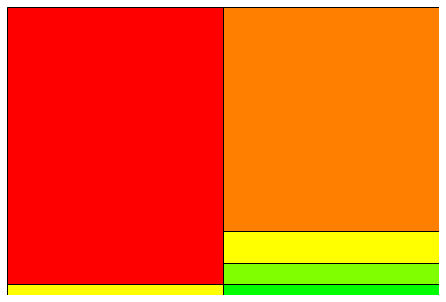

In [323]:
# Create Background Image for Age Chart
fig, ax = plt.subplots(frameon=False)
chart_range = percentiles+[100]
for i,percentile in enumerate(chart_range[::-1]): # [::-1] make sure we go from 100 to lowest value because chart overdraws.
    colour_gradient = i/(len(chart_range)-1)
    colour_rgb = get_color(red_to_green=i/(len(chart_range)-1))
    #print(percentile, colour_gradient, colour_rgb)
    ax.bar(plot_data_df.index, plot_data_df[percentile].values, color=colour_rgb,width=1.0,edgecolor='black')
save('background.png',fig=fig)

### Prototype Ageing chart 

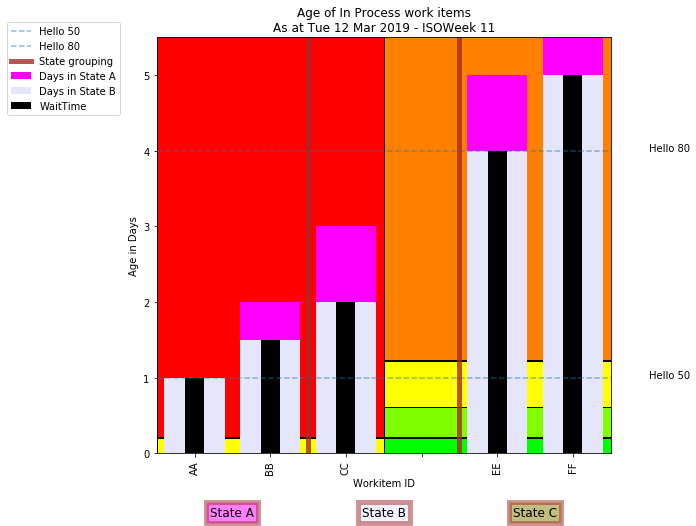

In [324]:
colours_list=['fuchsia','lavender','olive','salmon','violet','cyan']
#plt.figure()
fig,ax = plt.subplots(figsize=(10,10),facecolor="w")
ax.set(xlabel='Workitem ID',
      ylabel='Age in Days',
      title='Age of In Process work items\n'+today_nice_str)
xvals = [2,3,4,5,6,7,]
yvals1 = [1,2,3,0,5,6]
yvals2 = [1,1.5,2,0,4,5]
labels=['AA','BB','CC','','EE','FF']

position = np.arange(len(xvals))
#im = plt.imread('background.png')
#plt.imshow(im)
plt.bar(position, yvals1, color= colours_list[0], align='center',label='Days in State A')
plt.bar(position, yvals2, color= colours_list[1], align='center',label='Days in State B')
plt.bar(position, yvals2, align='center',width=0.25,color='black',label='WaitTime')

plt.axhline(y=1,alpha=0.5,linestyle='--',label='Hello 50')
ax.text(len(xvals),1, "Hello 50")
plt.axhline(y=4,alpha=0.5,linestyle='--',label='Hello 80')
ax.text(len(xvals),4, "Hello 80")

plt.axvline(x=1.5,alpha=0.8,linestyle='-',linewidth=5,color='brown',label="State grouping")
plt.axvline(x=3.5,alpha=0.8,linestyle='-',linewidth=5,color='brown')

plt.xticks(position, labels, rotation='vertical')
ax.text(1/6,-0.15, "State A", size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[0], alpha=0.5, linewidth=5,edgecolor='brown'))
ax.text(.5,-0.15, "State B", size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[1], alpha=0.5, linewidth=5,edgecolor='brown'))
ax.text(5/6,-0.15, "State C", size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[2], alpha=0.5, linewidth=5,edgecolor='brown'))
#ymin, ymax = ax.get_ylim()
#ax2.set_ylim(ymin,ymax)
#ax2.plot([],[])
img = plt.imread('background.png')
plt.imshow(img,zorder=0,  extent=[-0.5, len(xvals)-0.5, 0.0, len(xvals)-0.5])
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
plt.tight_layout()
plt.savefig(today_str+'_Age_of_Work_In_Process.png')

# Now create chart based on actual data

In [325]:
metrics_df.loc[~metrics_df['Age'].isnull(),['ID']+in_process_states]

,ID,Next,InProgress
19,1,0.0,27.0
20,21,0.0,27.0
21,33,0.0,27.0
22,24,0.0,6.0
23,30,0.0,6.0
24,35,0.0,6.0
25,29,0.0,2.0
26,22,23.0,NaN


In [326]:
InProcessWorkItems=metrics_df.loc[~metrics_df['Age'].isnull(),['ID']]['ID'].values.tolist()

In [327]:
# Work out what state each of the current in Process Work Items is in.
data=[]
for row in activities_df.loc[activities_df['ID'].isin(InProcessWorkItems),['ID']+workflow_cycle+removed_state].itertuples():
    ID=getattr(row, "ID")
    break_flag = False
    for i in range(0,len(workflow_cycle)):
        #print(i,ID, workflow_cycle[i],workflow_cycle[i+1])
        first_state=getattr(row,workflow_cycle[i])
        next_state=getattr(row,workflow_cycle[i+1])
        #print(first_state, next_state)
        if next_state is pd.NaT:
            next_state = pd.Timestamp('today')
            break_flag = True
        if break_flag:
            break
    data.append(dict({'ID': ID,
                  'state': workflow_cycle[i],
                  }))

current_state_df = pd.DataFrame(data)


In [328]:
current_state_df=current_state_df.set_index('ID')

In [329]:
current_state_df

,state
ID,
1,InProgress
21,InProgress
33,InProgress
24,InProgress
30,InProgress
35,InProgress
29,InProgress
22,Next


In [330]:
# Add a 'state' column to each of the "In Process" work items.
if not 'state' in metrics_df.columns:
    metrics_df = pd.merge(metrics_df,current_state_df,on='ID', how='left')

In [331]:
max_work_items_per_state = metrics_df.groupby(['state'])['ID'].count().max()

In [332]:
# Sanity check for data
metrics_df.loc[(~metrics_df['Age'].isnull()),['ID','state','WaitTime']+in_process_states]

,ID,state,WaitTime,Next,InProgress
19,1,InProgress,NaN,0.0,27.0
20,21,InProgress,NaN,0.0,27.0
21,33,InProgress,NaN,0.0,27.0
22,24,InProgress,NaN,0.0,6.0
23,30,InProgress,NaN,0.0,6.0
24,35,InProgress,NaN,0.0,6.0
25,29,InProgress,NaN,0.0,2.0
26,22,Next,27.0,23.0,NaN


In [333]:
# Create an empty matrix, that has enough columns to ensure that work item data aligns with the state percentile back ground color image.
plot_matrix = [ [0]*(len(in_process_states)+3) for i in range(max_work_items_per_state * len(in_process_states) )]

In [334]:
# Create a list of lists matrix that can be ised to create a dataframe 
for i, v in enumerate(in_process_states):
    j=0
    for row in metrics_df.loc[(~metrics_df['Age'].isnull()) & (metrics_df['state']==v),['ID','state','WaitTime']+in_process_states].itertuples():
        rowIndex=i*max_work_items_per_state+j
        #print(rowIndex,row)
        plot_matrix[rowIndex]=[getattr(row, "state"),getattr(row, "ID"),getattr(row, "WaitTime")] + [getattr(row, state) for state in in_process_states] #,getattr(row, "Next"),getattr(row, "InProgress")]
        j=j+1

In [335]:
in_process_df = pd.DataFrame(plot_matrix,columns=['state','ID','WaitTime']+in_process_states)
in_process_df.fillna(0,inplace=True)
in_process_df['ID'].replace(0,'', inplace=True) # Look better on the plot when emplty rather than has ID = 0



In [336]:
# need to be statcked bar ??? No I dont think so.
# see https://stackoverflow.com/questions/49889398/plot-stacked-bar-chart-from-pandas-data-frame

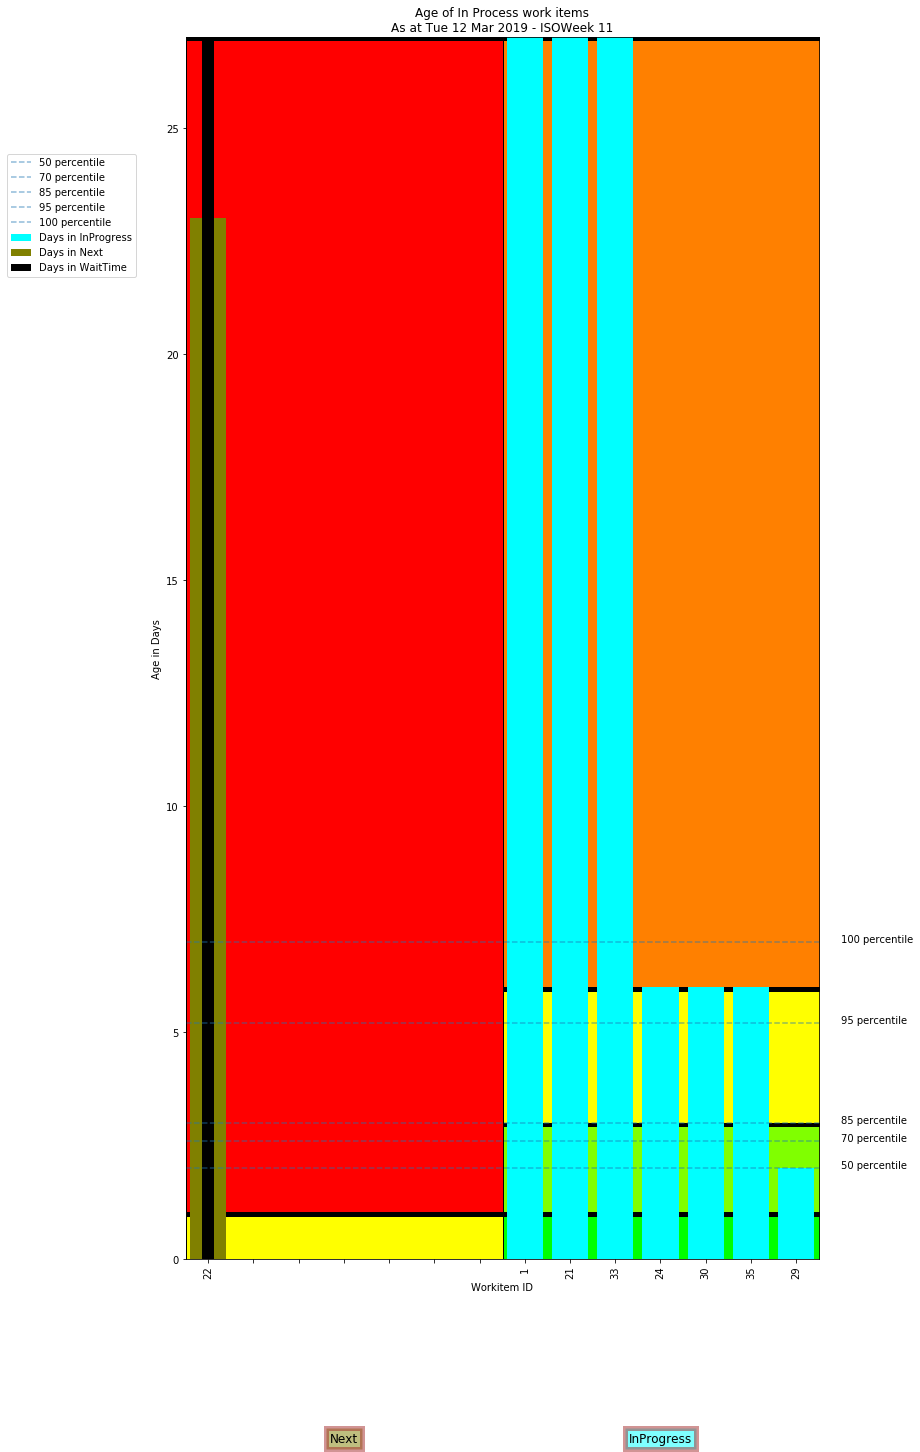

In [337]:
colours_list=['cyan','olive','cornflowerblue','lavender','blueviolet','cyan']  # See https://matplotlib.org/gallery/color/named_colors.html
fig,ax = plt.subplots(figsize=(40,20),facecolor="w")
ax.set(xlabel='Workitem ID',
      ylabel='Age in Days',
      title='Age of In Process work items\n'+today_nice_str)
labels=list(in_process_df['ID'].values)
position = np.arange(in_process_df.shape[0])
state_width = 1/len(in_process_states)
# Might not need this - Verticallines to show state changes
#for i, mystate in enumerate(in_process_states[::-1]):
#    print(i, len(in_process_states),in_process_df.shape[0], in_process_df.shape[0]/len(in_process_states), state_width*((len(in_process_states)-i))-state_width/2, i*in_process_df.shape[0]/2-0.5)
#    plt.axvline(x=(in_process_df.shape[0]/len(in_process_states)-1),alpha=0.8,linestyle='-',linewidth=5,color='brown') 
    
for i, mystate in enumerate(in_process_states[::-1]):
    plt.bar(position, list(in_process_df[mystate].values), color= colours_list[i], align='center',label='Days in '+mystate)
    ax.text( state_width*((len(in_process_states)-i))-state_width/2,-0.15, mystate, size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[i], alpha=0.5, linewidth=5,edgecolor='brown')) 


plt.bar(position, list(in_process_df['WaitTime'].values), align='center',width=0.25,color='black',label='Days in WaitTime')
plt.xticks(position, labels, rotation='vertical')

for row in percentiles_age_distribution_df[['P','FT']].itertuples():
    plt.axhline(y=getattr(row,'FT'),alpha=0.5,linestyle='--',label=str(getattr(row,'P'))+ " percentile")
    ax.text(len(position),getattr(row,'FT'), str(getattr(row,'P')) + " percentile")

#ax.text(state_width*(1+i)-state_width/2,-0.15, "State A", size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[0], alpha=0.5, linewidth=5,edgecolor='brown'))
#ax.text(.75,-0.15, "State B", size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[1], alpha=0.5, linewidth=5,edgecolor='brown'))
#plt.axvline(x=0.5,alpha=0.8,linestyle='-',linewidth=5,color='brown',label="State grouping")
#ax.text(5/6,-0.15, "State C", size=12, ha="center", transform=ax.transAxes,bbox=dict(facecolor=colours_list[2], alpha=0.5, linewidth=5,edgecolor='brown'))
    
img = plt.imread('background.png')
plt.imshow(img,zorder=0,  extent=[-0.5, in_process_df.shape[0]-0.5, 0.0, plot_data_df[100].max()])
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
plt.tight_layout()
plt.savefig(today_str+'_Age_of_Work_In_Process.png')

# Work on the DATA sheet

## Count the daily number of activities for each workflow cycle state(column) (Backlog, Next, In-progress, Done),

## Create data structure for issue ID, Date and State

Enables one to count the number of issues in a given state for a given date.

In [338]:
data=[]
for row in activities_df[['ID']+workflow_cycle+removed_state].itertuples():
    ID=getattr(row, "ID")
    break_flag = False
    for i in range(0,len(workflow_cycle)-1):
        #print(workflow_cycle[i],workflow_cycle[i+1])
        first_state=getattr(row,workflow_cycle[i])
        next_state=getattr(row,workflow_cycle[i+1])
        if next_state is pd.NaT:
            next_state = pd.Timestamp('today')
            break_flag = True
        dates=(pd.date_range(start=first_state, end=next_state, freq='D').tolist())
        #print(ID,first_state,next_state)
        
        for day in dates:
            #print(day,ID,workflow_cycle[i])
            data.append(dict({'Date': day,
                              'ID': ID,
                              'state': workflow_cycle[i],
                              }))
        
               
        if break_flag:
            break
    # Need a section to calculate entries for all issues that are done with dates from when done to now.         
    DoneState = getattr(row,workflow_cycle[-1]) # Assume that the final DONE workflow cycle state is located in right most call of array.
    if DoneState is not pd.NaT:
        #Issue in "DONE"
        first_state=DoneState
        next_state=pd.Timestamp('today') + pd.to_timedelta(1, unit='D')
        dates=(pd.date_range(start=first_state, end=next_state, freq='D').tolist())
        for day in dates:
            #print(day,ID,workflow_cycle[i])
            data.append(dict({'Date': day,
                              'ID': ID,
                              'state': workflow_cycle[-1],
                              }))
        
        
statehistory_df = pd.DataFrame(data)

In [339]:
statehistory_df.head(10)

,Date,ID,state
0,2019-02-09,6,Backlog
1,2019-02-10,6,Backlog
2,2019-02-11,6,Backlog
3,2019-02-12,6,Backlog
4,2019-02-13,6,Backlog
5,2019-02-14,6,Backlog
6,2019-02-15,6,Backlog
7,2019-02-16,6,Backlog
8,2019-02-17,6,Backlog
9,2019-02-18,6,Backlog


### Remove states on or after deleted date 

In [340]:
deleted_df=activities_df.loc[activities_df['Deleted'].notnull(),['ID','Deleted']]

In [341]:
for row in deleted_df.itertuples():
    ID=getattr(row,'ID')
    DeletedDate=getattr(row,'Deleted')
    statehistory_df=statehistory_df[~((statehistory_df.Date>=DeletedDate)  & (statehistory_df.ID==ID)) ] # statehistory_df.ID==ID & 

In [342]:
statehistory_df.head(10)

,Date,ID,state
0,2019-02-09,6,Backlog
1,2019-02-10,6,Backlog
2,2019-02-11,6,Backlog
3,2019-02-12,6,Backlog
4,2019-02-13,6,Backlog
5,2019-02-14,6,Backlog
6,2019-02-15,6,Backlog
7,2019-02-16,6,Backlog
8,2019-02-17,6,Backlog
9,2019-02-18,6,Backlog


In [343]:
# When multiple state transitions happen in a day for an issue, keep the last one. Do not want to double count the sane issue in multiple states in the same day. 
statehistory_df=statehistory_df.groupby(['Date','ID']).last()

In [344]:
statehistory_df.head(10)

,,state
Date,ID,
2019-01-21,14,Backlog
2019-01-22,14,Backlog
2019-01-23,14,Backlog
2019-01-24,14,Backlog
2019-01-25,14,Backlog
2019-01-26,14,Backlog
2019-01-27,14,Backlog
2019-01-28,14,Backlog
2019-01-29,14,Backlog


In [345]:
#count the number of issues in a given state every day
statehistory_df=statehistory_df.groupby(['Date','state']).size().reset_index(name='Count')

In [346]:
data_df=pd.pivot_table(statehistory_df, values = 'Count', index=['Date'], columns = 'state').reset_index()

In [347]:
data_df=data_df[['Date']+workflow_cycle] #Sort the columns into workflow sequence 

In [348]:
# Add an additional zero row at the top of table
data_series=activities_df[workflow_cycle].min()
from_date=data_series.min() - pd.to_timedelta(1, unit='D')
# new line
line = pd.DataFrame({'Date': from_date }, index=[0])
# concatenate two dataframe
data_df = pd.concat([line,data_df.iloc[:]],sort=False).reset_index(drop=True)

In [349]:
 # Replace NaN's with 0 (Zero)  for all columns.   axis : {0, 1, ‘index’, ‘columns’}
data_df.fillna(value=0, axis=1, inplace=True)

In [350]:
data_df.tail(10)

,Date,Backlog,Next,InProgress,Done
43,2019-03-04,17.0,1.0,4.0,10.0
44,2019-03-05,17.0,1.0,4.0,10.0
45,2019-03-06,19.0,1.0,4.0,10.0
46,2019-03-07,18.0,1.0,7.0,10.0
47,2019-03-08,18.0,1.0,7.0,11.0
48,2019-03-09,18.0,1.0,7.0,11.0
49,2019-03-10,15.0,1.0,7.0,12.0
50,2019-03-11,15.0,1.0,7.0,13.0
51,2019-03-12,15.0,1.0,7.0,13.0
52,2019-03-13,0.0,0.0,0.0,13.0


### Count the daily (cumulated) number of Deleted activities

In [351]:
#Are these any deleted issues? Quick peak at the top of the Deleted column.
activities_df['Deleted'].head(10)

0   2019-02-24
1          NaT
2          NaT
3          NaT
4          NaT
5          NaT
6   2019-03-01
7          NaT
8          NaT
9          NaT
Name: Deleted, dtype: datetime64[ns]

In [352]:
data_df['Deleted']=data_df.apply(lambda x: activities_df[activities_df.Deleted <= x.Date].shape[0] ,axis=1)

In [353]:
data_df.head(10)

,Date,Backlog,Next,InProgress,Done,Deleted
0,2019-01-20,0.0,0.0,0.0,0.0,0
1,2019-01-21,1.0,0.0,0.0,0.0,0
2,2019-01-22,1.0,0.0,0.0,0.0,0
3,2019-01-23,1.0,0.0,0.0,0.0,0
4,2019-01-24,1.0,0.0,0.0,0.0,0
5,2019-01-25,1.0,0.0,0.0,0.0,0
6,2019-01-26,1.0,0.0,0.0,0.0,0
7,2019-01-27,1.0,0.0,0.0,0.0,0
8,2019-01-28,1.0,0.0,0.0,0.0,0
9,2019-01-29,1.0,0.0,0.0,0.0,0


## Set of actually cumulative daily data of activities for each workflow cucle state. (Backlog, Next, In-progress, Done);

In [354]:
workflow_cycle

['Backlog', 'Next', 'InProgress', 'Done']

In [355]:
#Do the cumulative sum. Need to reverse order of cycle states
cumsum_df=data_df[workflow_cycle[::-1]].cumsum(axis=1)[workflow_cycle]
# Example of calculation df[df.columns[::-1]].cumsum(axis=1)[df.columns]
# Using [::-1] to reverse a list

In [356]:
cumsum_df.head(5)

,Backlog,Next,InProgress,Done
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [357]:
new_state_headings = ["cumsum" + str(x) for x in workflow_cycle]
ColumnNameMapping = dict(zip(workflow_cycle, new_state_headings))
ColumnNameMapping

{'Backlog': 'cumsumBacklog',
 'Next': 'cumsumNext',
 'InProgress': 'cumsumInProgress',
 'Done': 'cumsumDone'}

In [358]:
cumsum_df.rename(columns=ColumnNameMapping, inplace=True)

In [359]:
workflow_cycle

['Backlog', 'Next', 'InProgress', 'Done']

In [360]:
workflow_cycle[::-1]

['Done', 'InProgress', 'Next', 'Backlog']

In [361]:
# Make sure that the new columns are in the same sequence as the workflow sycle states columns.
#cumsum_df=cumsum_df[["cumsum" + str(x) for x in workflow_cycle[::-1]]]
cumsum_df=cumsum_df[["cumsum" + str(x) for x in workflow_cycle]]


In [362]:
cumsum_df.head(5)

,cumsumBacklog,cumsumNext,cumsumInProgress,cumsumDone
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [363]:
# For debugging purposes
#data_df.drop(["cumsum" + str(x) for x in workflow_cycle],axis=1,inplace=True)

In [364]:
data_df.head(5)

,Date,Backlog,Next,InProgress,Done,Deleted
0,2019-01-20,0.0,0.0,0.0,0.0,0
1,2019-01-21,1.0,0.0,0.0,0.0,0
2,2019-01-22,1.0,0.0,0.0,0.0,0
3,2019-01-23,1.0,0.0,0.0,0.0,0
4,2019-01-24,1.0,0.0,0.0,0.0,0


In [365]:
data_df =pd.concat([data_df, cumsum_df], axis=1)

In [366]:
data_df.head(4)

,Date,Backlog,Next,InProgress,Done,Deleted,cumsumBacklog,cumsumNext,cumsumInProgress,cumsumDone
0,2019-01-20,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,2019-01-21,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
2,2019-01-22,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0
3,2019-01-23,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0


## Daily Delivery Rate (DR)

The number of completed activities for the day, that is the number of activities moved to Done column and not deleted/discarded;

In [367]:
data_df['DR']=data_df[finished_state].astype(float).rolling(window=2).apply(lambda x: x[1] - x[0],raw=True)

## mDR - the moving average delivery rate since the initial period (mDR);

In [368]:
data_df['mDR'] = data_df['DR'].astype(float).expanding(min_periods=1).mean()

In [369]:
data_df.head(5)

,Date,Backlog,Next,InProgress,Done,Deleted,cumsumBacklog,cumsumNext,cumsumInProgress,cumsumDone,DR,mDR
0,2019-01-20,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN
1,2019-01-21,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-22,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-23,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-24,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0


## WIP metrics 

WIP = Work In Process  
Note: "In Process" not "In Progress"

* the daily WIP, the number of currently ongoing activities (Next plus In-progress);
* the moving average WIP since the initial period (mWIP);
* the moving average WIP of the latest seven days (mWIP(7));

In [370]:
data_df['WIP']=data_df[in_process_states].astype(float).sum(axis=1)

In [371]:
data_df['mWIP'] = data_df['WIP'].astype(float).expanding(min_periods=1).mean()

In [372]:
data_df['mWIP7'] = data_df['WIP'].astype(float).rolling(window=7).mean()

* the actual Daily Effort per activity, as the multiplicative inverse of WIP (1 / WIP);

In [373]:
data_df['DainlyEffort'] = 1/data_df['WIP']

## the daily mArrival and mThr rates for activities as described in Actionable Agile Metrics for Predictability book (as "Incoming" and "Outgoing");

### mArrival = (first count of Next - Cumulative Sum of count of Next )/ (days since first count)

numerator/denominator

In [374]:
data_df['numerator']=data_df['cumsum'+started_state].expanding(min_periods=1).apply(lambda x: (x[-1]-x[0]),raw=True)

In [375]:
first_date=data_df['Date'].iloc[0]

In [376]:
data_df['denominator']=data_df['Date'].apply(lambda x: (x-first_date).days )

In [377]:
data_df['mArrival']=data_df.apply(lambda row: (row.numerator/row.denominator) if (row.denominator> 0) else np.NaN,axis=1)

### mThr = (first count of Done - Cumulative Sum of count of Done ) / ((days since second count) + 1)

In [378]:
data_df['numerator']=data_df['cumsum'+finished_state].expanding(min_periods=1).apply(lambda x: (x[-1]-x[0]),raw=True)

In [379]:
first_date=data_df['Date'].iloc[1]

In [380]:
data_df['denominator']=data_df['Date'].apply(lambda x: (x-first_date).days + 1 )

In [381]:
data_df['mThr']=data_df.apply(lambda row: (row.numerator/row.denominator) if (row.denominator> 0) else np.NaN,axis=1)

In [382]:
data_df['mThr7'] = data_df['mThr'].astype(float).rolling(window=7).mean()

## Average lead time (mLT) computed as mWIP / mThr;


In [383]:
data_df['mLT']=data_df.apply(lambda row: (row.mWIP/row.mThr) if (row.mThr> 0) else np.NaN,axis=1)

## average lead time (mLT(7)) computed as mWIP(7) / mThr(7);

In [384]:
data_df['mLT7']=data_df.apply(lambda row: (row.mWIP7/row.mThr7) if (row.mThr7> 0) else np.NaN,axis=1)

## Approximate Average Lead Time (AALT)

computed as described in Actionable Agile Metrics for Predictability book.

also see https://chronologist.com/blog/2015-03-12/actionable-agile-metrics-review-part-4/

In [385]:
#todo

## Flow Time Histogram and Distribution Calculations

In [386]:
metrics_df.columns

Index([        'ID',       'Name',    'Backlog',       'Next', 'InProgress',
             'Done',        'Age',         'FT',        'mFT',           50,
                 70,           85,           95,   'WaitTime',     'Impact',
       'Likelihood',       'Risk',         'FE',        'mFE',      'state'],
      dtype='object')

# Charts

The images will be saved to disk. 

Alternatively for manual save use Shift + Right click MS-Windows / Linux, or for a mac, hold down shift while doing the two-finger click to bring up menu to save image.

In [387]:
# Data for Flow Time Histogram
results=metrics_df['FT'].value_counts(sort=False, dropna=True)
results.sort_index(inplace=True)
#vals, counts = np.unique(metrics_df['FT'], return_counts=True)
#results = dict(zip(vals, counts))

In [388]:
results

1.0    8
2.0    5
3.0    4
5.0    1
7.0    1
Name: FT, dtype: int64

In [389]:
max_xrange=results.index[-1]+2

In [390]:
max_xrange

9.0

In [391]:
max_yrange=results.max() + 2

In [392]:
data_series=metrics_df.loc[~metrics_df['FT'].isnull(),'FT']  # Drop all the Null values

In [393]:
bins = [i for i in range(1,int(max_xrange),1)]

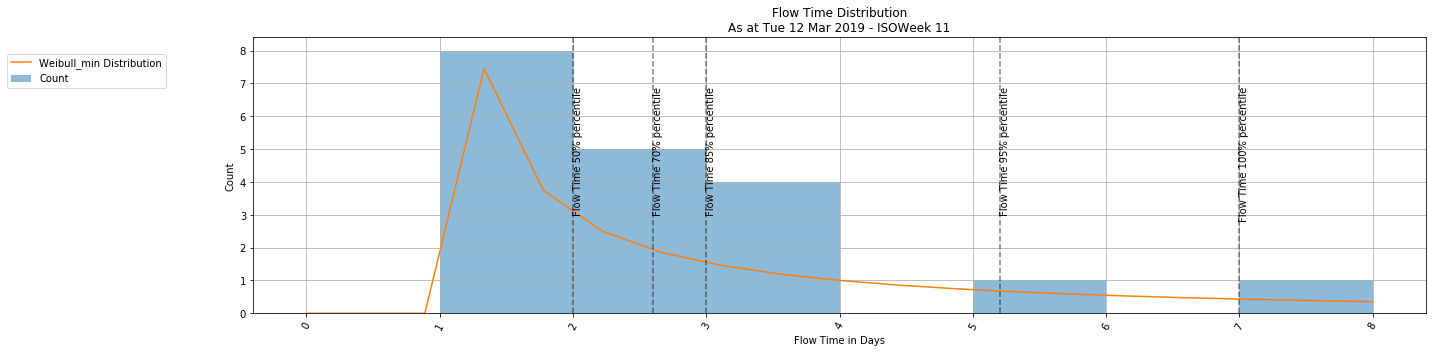

In [394]:
# https://stackoverflow.com/questions/41024455/histogram-with-non-normalized-fit-line-matplotlib

fig,ax = plt.subplots(figsize=(20,5),facecolor="w")
# plot normed histogram
n, bins, patches = plt.hist(data_series,bins=bins, density=False, alpha=0.5,label="Count")

# Major ticks every 20, minor ticks every 5
major_xticks = np.arange(0, max_xrange, 1)
minor_xticks = np.arange(0, max_xrange, 5)
major_yticks = np.arange(0, max_yrange, 1)
minor_yticks = np.arange(0, max_yrange, 5)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)
plt.setp(ax.get_xticklabels(),rotation=60)
# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(data_series))

ag,bg,cg = stats.weibull_min.fit(data_series)  
pdf_weibull = stats.weibull_min.pdf(lnspc, ag, bg,cg)  * sum(n * np.diff(bins))
plt.plot(lnspc, pdf_weibull, label="Weibull_min Distribution")

plt.grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
ax.set(xlabel='Flow Time in Days',
      ylabel='Count',
      title='Flow Time Distribution\n'+today_nice_str)

for row in percentiles_age_distribution_df[['P','FT']].itertuples():
    plt.axvline(getattr(row,'FT'),alpha=0.5,color='k',linestyle='--',label=str(getattr(row,'P'))+ " percentile")
#    ax.text(len(position),getattr(row,'FT'), str(getattr(row,'P')) + " percentile")
#plt.axvline(10, color='k', linestyle='dashed', linewidth=2)
    plt.text(getattr(row,'FT'),2*max_yrange/3,'Flow Time '+str(getattr(row,'P')) + "% percentile",rotation='vertical')

plt.tight_layout()
plt.savefig(today_str+'_Flow_Time_Histogram.png')
#plt.show()


## Scatter plot - Matplotlib

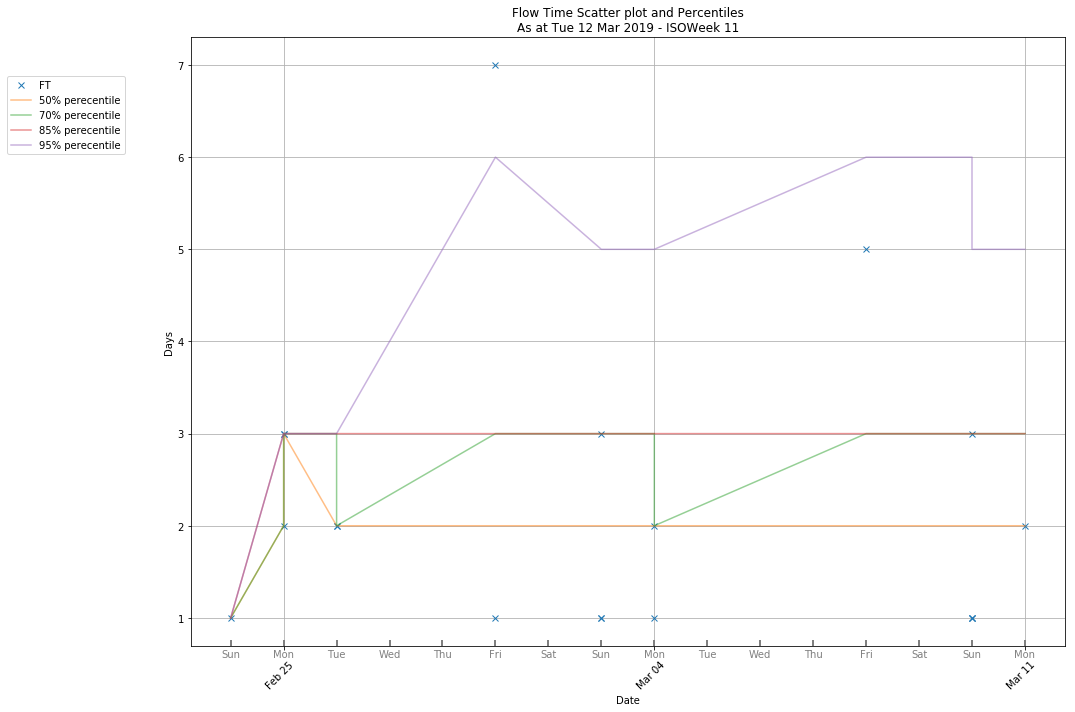

In [408]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(metrics_df[finished_state], metrics_df['FT'],lw=0,marker='x') # Bit of a trick to convert line chart to be scatter by setting linewidth to zero and add markers.
for percentile in percentiles:
    values=metrics_df.loc[metrics_df[finished_state].notnull(),[finished_state,percentile]].drop_duplicates()
    ax.plot(list(values[finished_state].values),list(values[percentile].values),label=str(percentile)+"% perecentile",alpha=0.5)

plt.setp(ax.get_xticklabels(),rotation=45)
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
plt.grid(True)
ax.set(xlabel='Date',
      ylabel='Days',
      title='Flow Time Scatter plot and Percentiles\n'+today_nice_str)
ax.tick_params(which='minor', direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d   '))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%a'))

plt.tight_layout()
plt.savefig(today_str+'_Done_FlowTime_Scatter_Plot_with_FT_Percentiles.png')
#plt.show()


## Cummulative Flow Diagram - Matplotlib

In [409]:
data_df[new_state_headings].tail(5)

,cumsumBacklog,cumsumNext,cumsumInProgress,cumsumDone
48,37.0,19.0,18.0,11.0
49,35.0,20.0,19.0,12.0
50,36.0,21.0,20.0,13.0
51,36.0,21.0,20.0,13.0
52,13.0,13.0,13.0,13.0


In [431]:
x=list(data_df['Date'].values)

In [433]:
num_colours=(len(workflow_cycle)+1)
sns.reset_orig()  # get default matplotlib styles back
mycolours = sns.color_palette('husl', n_colors=num_colours)  # a list of RGB tuples

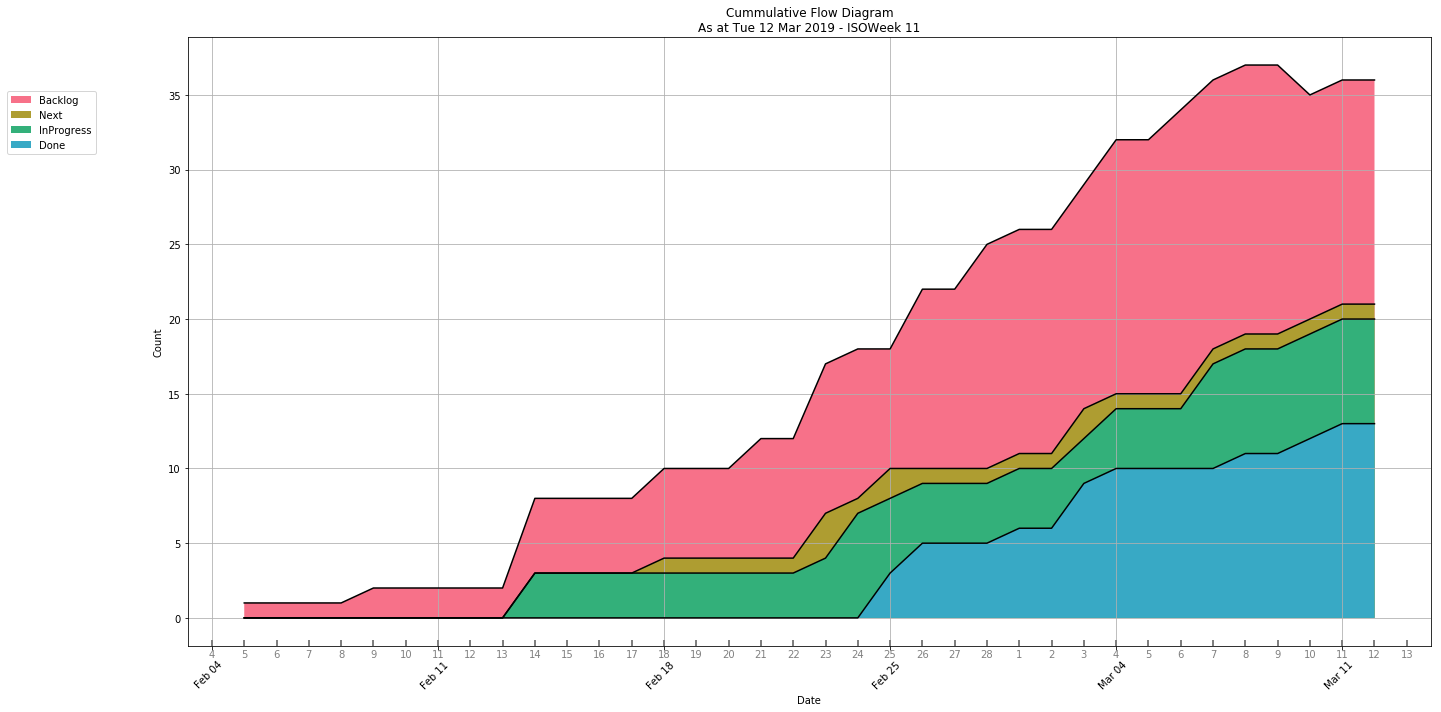

In [440]:
last_n_days=90 #How many days should the run book go back for?
# Create the plot space upon which to plot
fig,ax = plt.subplots(figsize=(20,10))
for i,state in enumerate(workflow_cycle):
    list(data_df['cumsum'+state].values)
    ax.plot(x[(len(x)-last_n_days):-1],list(data_df['cumsum'+state].values)[(len(x)-last_n_days):-1],color='black')
    ax.fill_between(x[(len(x)-last_n_days):-1],0,list(data_df['cumsum'+state].values)[(len(x)-last_n_days):-1],label=state,facecolor=mycolours[i])

plt.setp(ax.get_xticklabels(),rotation=45)
plt.grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
ax.set(xlabel='Date',
      ylabel='Count',
      title='Cummulative Flow Diagram\n'+today_nice_str)
ax.tick_params(which='minor', direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d   '))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%-d'))

plt.tight_layout()
plt.savefig(today_str+'_CFD.png')
#plt.show()

### Daily Run Chart - Matplotlib

In [443]:
for i,state in enumerate(refinement_states + ['DR','WIP']):
    print(state)

Backlog
DR
WIP


In [444]:
x=list(data_df['Date'].values)

In [445]:
num_colours=(len(refinement_states)+2)
sns.reset_orig()  # get default matplotlib styles back
mycolours = sns.color_palette('husl', n_colors=num_colours)  # a list of RGB tuples

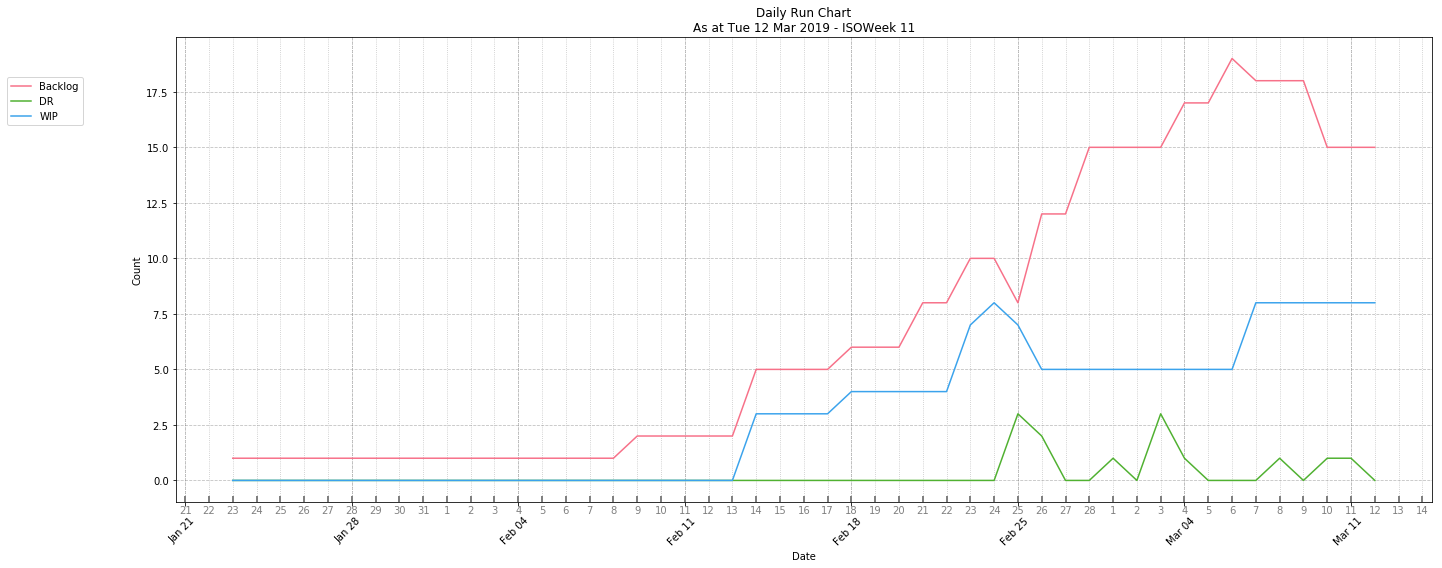

In [446]:
last_n_days=50 #How many days should the run book go back for?
# Create the plot space upon which to plot
fig,ax = plt.subplots(figsize=(20,8))
for i,state in enumerate(refinement_states + ['DR','WIP']):
    ax.plot(x[-last_n_days:-1],list(data_df[state].values)[-last_n_days:-1],label=state,color=mycolours[i])

plt.setp(ax.get_xticklabels(),rotation=45)
#plt.grid(True)
plt.grid(b=True, which='major', color='gray', linestyle='--',alpha=0.5)
plt.grid(b=True, which='minor', color='gray', linestyle=':',alpha=0.5)
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
ax.set(xlabel='Date',
      ylabel='Count',
      title='Daily Run Chart\n'+today_nice_str)
ax.tick_params(which='minor', direction='in', length=6, width=2, colors='gray')
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d   '))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%-d'))
plt.tight_layout()
plt.savefig(today_str+'_Daily_run_chart.png')
#plt.show()

## Flow Efficiency FE and mFE Matplotlib

In [447]:
metrics_df.columns

Index([        'ID',       'Name',    'Backlog',       'Next', 'InProgress',
             'Done',        'Age',         'FT',        'mFT',           50,
                 70,           85,           95,   'WaitTime',     'Impact',
       'Likelihood',       'Risk',         'FE',        'mFE',      'state'],
      dtype='object')

In [448]:
x=list(metrics_df[finished_state].values)
y1=list(metrics_df['FE'].values)
y2=list(metrics_df['mFE'].values)

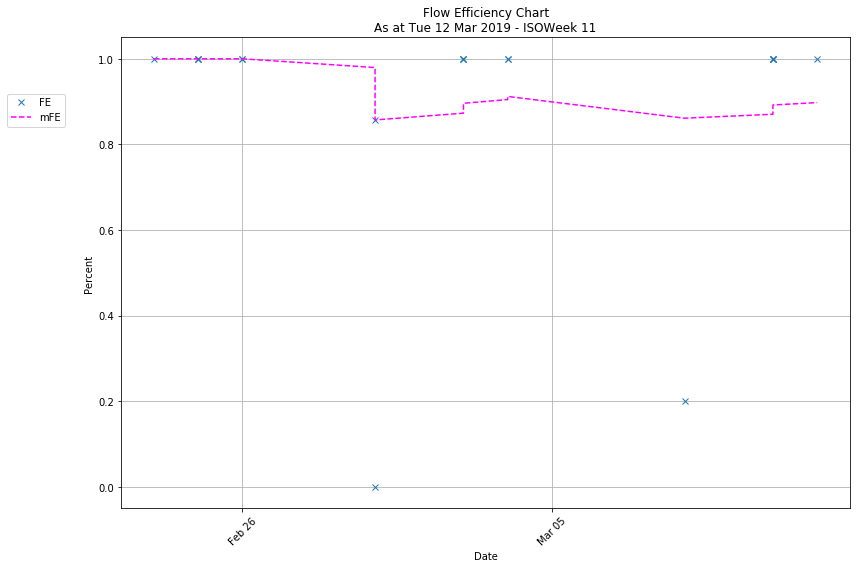

In [449]:
# Create the plot space upon which to plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(x,y1,lw=0,label="FE",marker='x') # Bit of a trick to convert line chart to be scatter by setting linewidth to zero and add markers.
ax.plot(x,y2,label="mFE",color='magenta',linestyle='--')
plt.setp(ax.get_xticklabels(),rotation=45)
plt.grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(-0.07,0.8))
ax.set(xlabel='Date',
      ylabel='Percent',
      title='Flow Efficiency Chart\n'+today_nice_str)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.savefig(today_str+'_Flow_Efficiency.png')
#plt.show()

## Class of Service Ratio Pie Chart - Matplotlib

In [450]:
if 'CoS' in activities_df.columns:
    cos=activities_df.groupby(['CoS']).size()
    sizes=list(cos.values)
    labels=list(cos.index)

In [451]:
if 'CoS' in activities_df.columns:
    print(cos)

CoS
Expedite       4
Fixed Date     5
Intangible    12
Standard      21
dtype: int64


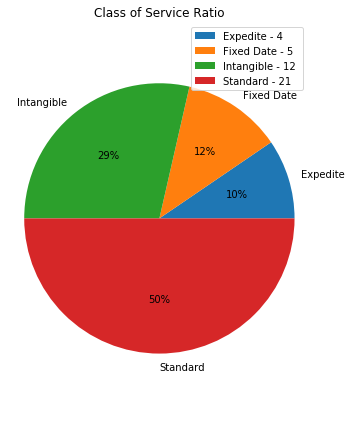

In [452]:
if 'CoS' in activities_df.columns:
    # Create the plot space upon which to plot
    # See link for more information on positiong the legend https://stackoverflow.com/questions/43272206/python-legend-overlaps-with-the-pie-chart
    fig,ax = plt.subplots(figsize=(5,6))
    patches, text, _ = plt.pie(sizes, labels= labels,autopct='%.0f%%')
    #axes[0].legend(bbox_to_anchor=(0, 0.5))
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.legend(patches, ['%s - %1.0f ' % (l, s) for l, s in zip(labels, sizes)],loc="best") #,bbox_to_anchor=(1,0), bbox_transform=plt.gcf().transFigure)
    plt.axis('equal')
    ax.set(title='Class of Service Ratio')
    plt.tight_layout()
    plt.savefig(today_str+'_Class_Of_Service_Ratios.png')
    #plt.show()
    

## Age in Workflow state Chart

In [453]:
metrics_df

,ID,Name,Backlog,Next,InProgress,Done,Age,FT,mFT,50,70,85,95,WaitTime,Impact,Likelihood,Risk,FE,mFE,state
0,6,What is the longest you've been awake?,15.0,0.0,0.0,2019-02-24,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
1,11,What are your favorite hot dog toppings?,0.0,1.0,1.0,2019-02-25,NaN,3.0,2.0,2.0,2.0,3.0,3.0,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
2,17,Where did you get your name?,0.0,1.0,1.0,2019-02-25,NaN,3.0,2.0,3.0,3.0,3.0,3.0,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
3,14,What is your favorite lunch meal?,34.0,0.0,1.0,2019-02-25,NaN,2.0,2.0,2.0,3.0,3.0,3.0,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
4,9,What do you do as excerise?,1.0,0.0,1.0,2019-02-26,NaN,2.0,2.0,2.0,3.0,3.0,3.0,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
5,13,"which do you like better, being a passenger or...",7.0,1.0,0.0,2019-02-26,NaN,2.0,2.0,2.0,2.0,3.0,3.0,NaN,0.000000,0.000000,0.000000,1.000000,1.000000,NaN
6,20,Have you ever fainted?,0.0,0.0,6.0,2019-03-01,NaN,7.0,3.0,2.0,3.0,3.0,6.0,1.0,0.142857,0.142857,0.020408,0.857143,0.979592,NaN
7,4,Have you ever bungee jumped?,0.0,0.0,0.0,2019-03-01,NaN,1.0,3.0,2.0,3.0,3.0,6.0,1.0,0.250000,0.250000,0.062500,0.000000,0.857143,NaN
8,16,Have you ever jumped out of a plane?,5.0,0.0,2.0,2019-03-03,NaN,3.0,3.0,2.0,3.0,3.0,5.0,NaN,0.222222,0.222222,0.049383,1.000000,0.873016,NaN
9,10,Do you like flying?,0.0,0.0,0.0,2019-03-03,NaN,1.0,2.0,2.0,3.0,3.0,5.0,NaN,0.200000,0.200000,0.040000,1.000000,0.885714,NaN


In [454]:
metrics_df.loc[~metrics_df['Age'].isnull()]

,ID,Name,Backlog,Next,InProgress,Done,Age,FT,mFT,50,70,85,95,WaitTime,Impact,Likelihood,Risk,FE,mFE,state
19,1,What is your favorite dinner meal?,0.0,0.0,27.0,NaT,27.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
20,21,What is your favorite cereal?,0.0,0.0,27.0,NaT,27.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
21,33,Have you ever been to a zoo?,0.0,0.0,27.0,NaT,27.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
22,24,Where do you see yourself in ten years?,1.0,0.0,6.0,NaT,6.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
23,30,"If you had to swap lives with someone famous, ...",1.0,0.0,6.0,NaT,6.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
24,35,What is your first memory?,0.0,0.0,6.0,NaT,6.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
25,29,"Which do you like better, TV or movies?",13.0,0.0,2.0,NaT,2.0,NaN,2.0,2.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,InProgress
26,22,What is your favorite holiday?,0.0,23.0,NaN,NaT,23.0,NaN,2.0,2.0,3.0,3.0,5.0,27.0,NaN,NaN,NaN,NaN,NaN,Next


# Save the data sheets to excel file

In [455]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
# Also set the default datetime and date formats.
writer = pd.ExcelWriter('WorkItems_' + today_str + '.xlsx',
                        engine='xlsxwriter',
                        datetime_format='yyyy-MM-dd',
                        date_format='yyyy-MM-dd',
                        options={'remove_timezone': True})

# Convert the dataframes to an XlsxWriter Excel object.
activities_df.to_excel(writer, sheet_name='activities',index=False)
data_df.to_excel(writer, sheet_name='data',index=False)
metrics_df.to_excel(writer, sheet_name='metrics',index=False)
distribution_df.to_excel(writer, sheet_name='distributions',index=False)
percentiles_age_distribution_df.to_excel(writer, sheet_name='percentiles',index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()